In [1]:
import pandas as pd
import waveg
import struct
import glob
import os
import warnings
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from tqdm import tqdm
%matplotlib inline
warnings.filterwarnings('ignore')

def parse_wave_python(filename):
    with wave.open(filename, 'rb') as wave_file:
        sample_rate = wave_file.getframerate()
        length_in_seconds = wave_file.getnframes() / sample_rate
        
        first_sample = struct.unpack(
            '<h', wave_file.readframes(1))[0]
        second_sample = struct.unpack(
            '<h', wave_file.readframes(1))[0]
    print('''
Parsed {filename}
-----------------------------------------------
Channels: {num_channels}
Sample Rate: {sample_rate}
First Sample: {first_sample}
Second Sample: {second_sample}
Length in Seconds: {length_in_seconds}'''.format(
            filename=filename,
            num_channels=wave_file.getnchannels(),
            sample_rate=wave_file.getframerate(),
            first_sample=first_sample,
            second_sample=second_sample,
            length_in_seconds=length_in_seconds))
        
parse_wave_python('Train_folder/train/1.wav')



Parsed Train_folder/train/1.wav
-----------------------------------------------
Channels: 1
Sample Rate: 48000
First Sample: -3939
Second Sample: -4940
Length in Seconds: 4.0


In [2]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 300)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()

In [3]:
sound_file_paths = ['Train_folder/train/0.wav', 'Train_folder/train/1.wav',
                    'Train_folder/train/2.wav', 'Train_folder/train/4.wav', 
                    'Train_folder/train/6.wav', 'Train_folder/train/12.wav', 
                    'Train_folder/train/17.wav', 'Train_folder/train/22.wav', 
                    'Train_folder/train/33.wav', 'Train_folder/train/48.wav']
sound_names = ['Siren', 'Street music', 'Drilling',
               'Dog bark', 'Children playing', 'Gun shot',
               'Engine idling', 'Air conditioner', 'Jackhammer',
               'Car horn']

raw_sounds = load_sound_files(sound_file_paths)
plot_waves(sound_names,raw_sounds)

In [8]:
#To extract the useful features from sound data, we will use Librosa library
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

In [9]:
mfccs, chroma, mel, contrast,tonnetz = extract_feature('Train_folder/train/4316.wav')

In [10]:
mfccs

array([-1.03483262e+02,  4.37438912e+01,  1.62066177e+01,  2.04347375e+01,
        2.18889983e+00,  2.40929443e+01,  8.44791575e+00,  2.73242543e+01,
        3.93113719e+00, -6.75690264e+00,  5.98093523e+00,  1.44193967e+01,
       -5.05454240e+00,  5.42332584e+00, -8.42011760e+00,  5.09449510e+00,
       -1.69607206e+00, -2.25535080e+00, -1.18245267e+00, -6.55411655e+00,
       -4.44424257e+00,  7.92568749e+00, -4.03099996e+00, -3.59425263e+00,
       -3.16242792e-02,  7.58745412e-01,  3.59599853e-01,  1.72537591e+00,
       -1.07468338e+00,  8.60886468e+00, -4.12876660e+00, -4.00765638e-01,
        6.55324621e+00, -7.58209877e+00, -4.13918052e+00, -8.27819963e-01,
       -4.91430500e+00,  5.49845310e+00, -9.06442783e+00,  5.51283659e+00])

In [11]:
# reading csv file  
df = pd.read_csv("Train_folder/train.csv") 
df.head()

ID         Class
0   0         siren
1   1  street_music
2   2      drilling
3   3         siren
4   4      dog_bark

In [13]:
lista = df['Class'].unique().tolist()

In [14]:
wavcatalog = [i for i in enumerate(lista)]

In [15]:
wavcatalog

[(0, 'siren'),
 (1, 'street_music'),
 (2, 'drilling'),
 (3, 'dog_bark'),
 (4, 'children_playing'),
 (5, 'gun_shot'),
 (6, 'engine_idling'),
 (7, 'air_conditioner'),
 (8, 'jackhammer'),
 (9, 'car_horn')]

In [16]:
#get drilling
wavcatalog[2][1]
#get tuple (2, drilling)
wavcatalog[2]

(2, 'drilling')

In [18]:
features, labels = np.empty((0,193)), np.empty(0)
for i in tqdm(range(df.shape[0])):
   number = df.iloc[i,0]
   label = df.iloc[i,1]
   filename = f'{number}.wav'
   lbl = f'{label}'
   try:
       mfccs, chroma, mel, contrast,tonnetz = extract_feature(f'Train_folder/train/{filename}')
   except:
       print(f"File {filename} didn't work")
       continue
   ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
   features = np.vstack([features,ext_features])
   if label == wavcatalog[0][1]:
        labels = np.append(labels, wavcatalog[0][0])
   elif label == wavcatalog[1][1]:
        labels = np.append(labels, wavcatalog[1][0])
   elif label == wavcatalog[2][1]:
        labels = np.append(labels, wavcatalog[2][0])
   elif label == wavcatalog[3][1]:
        labels = np.append(labels, wavcatalog[3][0])
   elif label == wavcatalog[4][1]:
        labels = np.append(labels, wavcatalog[4][0])
   elif label == wavcatalog[5][1]:
        labels = np.append(labels, wavcatalog[5][0])
   elif label == wavcatalog[6][1]:
        labels = np.append(labels, wavcatalog[6][0])
   elif label == wavcatalog[7][1]:
        labels = np.append(labels, wavcatalog[7][0])
   elif label == wavcatalog[8][1]:
        labels = np.append(labels, wavcatalog[8][0])
   elif label == wavcatalog[9][1]:
        labels = np.append(labels, wavcatalog[9][0])
  
   #labels = np.append(labels, fn.split('/')[2].split('-')[1])
    #return np.array(features), np.array(labels, dtype = np.int)
   
   #print(chroma)
   #print(filename)
   #print(lbl)
#     print(df.iloc[i,0])

100%|██████████████████████████████████████████████████████████████████████████████| 5435/5435 [58:18<00:00,  1.63it/s]


In [19]:
labels

array([0., 1., 2., ..., 6., 6., 7.])

In [20]:
features

array([[-7.50957191e+01,  1.29611846e+02, -3.26698975e+01, ...,
         1.57509179e-03, -5.37471939e-03,  5.26261495e-03],
       [-8.35056669e+00,  1.13704109e+02, -1.91475123e+01, ...,
        -5.36374958e-03,  2.90953126e-03, -1.54599678e-03],
       [-1.15225264e+02,  3.67671473e+00, -3.87245168e+01, ...,
         2.73520672e-02, -9.37955141e-03, -4.78768348e-03],
       ...,
       [-3.12261079e+02,  4.62412806e+01,  5.05164659e+00, ...,
         1.62614482e-01, -3.83779053e-02, -1.89554327e-02],
       [-2.71249094e+02,  1.33006300e+02, -2.83203666e+01, ...,
         2.02666673e-01, -1.93794808e-02, -5.00848620e-02],
       [-2.91026597e+02,  2.33391865e+02, -4.70676553e+00, ...,
         5.15215980e-02,  1.03867911e-02, -1.45272843e-02]])

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_samples = scaler.fit_transform(features)

In [22]:
scaled_train_samples

array([[0.71283036, 0.59447857, 0.56851254, ..., 0.40620691, 0.46932733,
        0.27467782],
       [0.78216945, 0.54631151, 0.62625267, ..., 0.39764163, 0.52111423,
        0.25072002],
       [0.67114125, 0.21315939, 0.54265952, ..., 0.43802591, 0.44429214,
        0.23931333],
       ...,
       [0.46644797, 0.34204071, 0.72958225, ..., 0.60499331, 0.26301626,
        0.18946056],
       [0.50905382, 0.60475664, 0.58708489, ..., 0.65443357, 0.38178011,
        0.07992387],
       [0.4885077 , 0.90871424, 0.68791416, ..., 0.46786068, 0.56785643,
        0.20504211]])

In [23]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

Using TensorFlow backend.


In [24]:
#Create Layers
model = Sequential([
    Dense(16, input_shape=(193,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                3104      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 3,978
Trainable params: 3,978
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(Adam(lr=.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit(scaled_train_samples, labels, validation_split=0.1, batch_size=10, epochs=200, shuffle=True, verbose=2)

Train on 4891 samples, validate on 544 samples
Epoch 1/200
 - 1s - loss: 0.7288 - acc: 0.7665 - val_loss: 0.8226 - val_acc: 0.7114
Epoch 2/200
 - 1s - loss: 0.7284 - acc: 0.7669 - val_loss: 0.8223 - val_acc: 0.7096
Epoch 3/200
 - 1s - loss: 0.7254 - acc: 0.7690 - val_loss: 0.8480 - val_acc: 0.6967
Epoch 4/200
 - 1s - loss: 0.7274 - acc: 0.7684 - val_loss: 0.8369 - val_acc: 0.7096
Epoch 5/200
 - 1s - loss: 0.7246 - acc: 0.7677 - val_loss: 0.8214 - val_acc: 0.7169
Epoch 6/200
 - 1s - loss: 0.7233 - acc: 0.7688 - val_loss: 0.8220 - val_acc: 0.7151
Epoch 7/200
 - 1s - loss: 0.7219 - acc: 0.7747 - val_loss: 0.8244 - val_acc: 0.7040
Epoch 8/200
 - 1s - loss: 0.7212 - acc: 0.7722 - val_loss: 0.8191 - val_acc: 0.7151
Epoch 9/200
 - 1s - loss: 0.7188 - acc: 0.7745 - val_loss: 0.8189 - val_acc: 0.7114
Epoch 10/200
 - 1s - loss: 0.7193 - acc: 0.7733 - val_loss: 0.8197 - val_acc: 0.7096
Epoch 11/200
 - 1s - loss: 0.7174 - acc: 0.7728 - val_loss: 0.8141 - val_acc: 0.7114
Epoch 12/200
 - 1s - loss: 

Epoch 97/200
 - 1s - loss: 0.6391 - acc: 0.8029 - val_loss: 0.7710 - val_acc: 0.7298
Epoch 98/200
 - 1s - loss: 0.6379 - acc: 0.8031 - val_loss: 0.7695 - val_acc: 0.7371
Epoch 99/200
 - 1s - loss: 0.6365 - acc: 0.8070 - val_loss: 0.7686 - val_acc: 0.7316
Epoch 100/200
 - 1s - loss: 0.6351 - acc: 0.8037 - val_loss: 0.7655 - val_acc: 0.7426
Epoch 101/200
 - 1s - loss: 0.6345 - acc: 0.8011 - val_loss: 0.7718 - val_acc: 0.7574
Epoch 102/200
 - 1s - loss: 0.6344 - acc: 0.8045 - val_loss: 0.7683 - val_acc: 0.7261
Epoch 103/200
 - 1s - loss: 0.6374 - acc: 0.8031 - val_loss: 0.7701 - val_acc: 0.7279
Epoch 104/200
 - 1s - loss: 0.6335 - acc: 0.8049 - val_loss: 0.7675 - val_acc: 0.7482
Epoch 105/200
 - 1s - loss: 0.6328 - acc: 0.8039 - val_loss: 0.7727 - val_acc: 0.7279
Epoch 106/200
 - 1s - loss: 0.6312 - acc: 0.8060 - val_loss: 0.7663 - val_acc: 0.7261
Epoch 107/200
 - 1s - loss: 0.6317 - acc: 0.8049 - val_loss: 0.7668 - val_acc: 0.7426
Epoch 108/200
 - 1s - loss: 0.6311 - acc: 0.8088 - val_lo

Epoch 193/200
 - 1s - loss: 0.5788 - acc: 0.8197 - val_loss: 0.7327 - val_acc: 0.7555
Epoch 194/200
 - 1s - loss: 0.5789 - acc: 0.8197 - val_loss: 0.7343 - val_acc: 0.7518
Epoch 195/200
 - 1s - loss: 0.5758 - acc: 0.8256 - val_loss: 0.7331 - val_acc: 0.7647
Epoch 196/200
 - 1s - loss: 0.5765 - acc: 0.8203 - val_loss: 0.7362 - val_acc: 0.7463
Epoch 197/200
 - 1s - loss: 0.5752 - acc: 0.8215 - val_loss: 0.7494 - val_acc: 0.7537
Epoch 198/200
 - 1s - loss: 0.5756 - acc: 0.8217 - val_loss: 0.7447 - val_acc: 0.7500
Epoch 199/200
 - 1s - loss: 0.5744 - acc: 0.8229 - val_loss: 0.7263 - val_acc: 0.7555
Epoch 200/200
 - 1s - loss: 0.5756 - acc: 0.8223 - val_loss: 0.7424 - val_acc: 0.7518


In [30]:
# Save the model
model.save("mnist_trained.h5")

In [31]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model("mnist_trained.h5")

In [32]:
#Notes-Validation loss should go down and validation accuracy goes up (which should be close to 1)
#Model has been trained to a .46 percent accuracy rate (that the data is categorized correctly ) 
#Increasing the Epoch to get closer to 1
#Turn array into dataframe, 

In [33]:
df_1 = pd.DataFrame(features)
df_1.head()

0           1          2          3          4          5    \
0  -75.095719  129.611846 -32.669898  15.285441  -2.378207  14.626390   
1   -8.350567  113.704109 -19.147512  29.386994 -13.745963   7.170843   
2 -115.225264    3.676715 -38.724517  -4.002133 -15.980845 -11.146253   
3 -211.840458   87.311125 -53.307992  10.788239 -46.073711  13.174044   
4 -235.825635  132.952580  42.155849  18.454956  12.176050  11.412190   

         6          7         8          9      ...           183        184  \
0  -3.764634  17.962046 -2.011992  14.395796    ...     13.581584  15.363746   
1 -12.804698   8.102789 -9.090141  -2.810667    ...     17.756826  18.226822   
2   1.778062   4.020408 -2.446081  11.607701    ...     14.026372  16.014877   
3  20.365529  14.869042  0.525608  -4.480130    ...     27.707668  21.865110   
4  -1.725005  10.437025 -0.802941   4.525129    ...     16.328094  16.194166   

         185        186       187       188       189       190       191  \
0  15.579746  35.387758 -0.004255  0.014481 -0.040944  0.001575 -0.005375   
1  16.085308  34.338946  0.003580  0.010518 -0.084111 -0.005364  0.002910   
2  17.438533  31.626253  0.001479 -0.004756  0.013443  0.027352 -0.009380   
3  26.985700  42.099477 -0.000115 -0.036755 -0.126207 -0.032240  0.059965   
4  16.016508  31.238708 -0.000755  0.010912  0.038104 -0.002897 -0.002296   

        192  
0  0.005263  
1 -0.001546  
2 -0.004788  
3 -0.026851  
4 -0.001802  

[5 rows x 193 columns]

In [34]:
chroma

array([0.71506648, 0.77021513, 0.70044269, 0.72784109, 0.94054654,
       0.45094541, 0.45398111, 0.41769169, 0.75254925, 0.86674994,
       0.65933695, 0.58184525])

In [35]:
mfccs

array([-2.91026597e+02,  2.33391865e+02, -4.70676553e+00,  4.67810543e+00,
        1.65518945e+01,  3.64023639e+00,  1.47995742e+01,  4.46623145e+00,
        4.33502610e+00,  8.88061131e+00,  3.20686321e+00,  3.88334884e+00,
        9.93451821e-01, -1.05600323e+00,  4.93780228e+00,  6.91566398e+00,
        3.23145224e+00, -4.60808952e+00, -7.58890372e+00, -5.96945275e-01,
        1.08831380e+00, -1.00955481e+00,  2.19535620e+00, -7.77371656e-01,
       -6.96977786e+00, -6.60477265e+00, -4.63290128e+00, -2.00019048e+00,
        3.09516474e-01,  1.04093821e+00,  4.55525992e+00,  5.63577893e+00,
        5.74717382e-01, -3.73062101e+00, -6.64239291e+00, -7.92701909e+00,
       -3.40596001e+00,  2.77268092e-01, -3.50107728e-01, -1.72377591e-02])

In [36]:
df_2 = pd.DataFrame(mfccs)
df_3 = pd.DataFrame(chroma)
df_4 = pd.DataFrame(mel)
df_5 = pd.DataFrame(contrast)
df_6 = pd.DataFrame(tonnetz)
#df_2.head()
df_2.describe()

0
count   40.000000
mean    -0.601548
std     59.983533
min   -291.026597
25%     -3.487125
50%      0.442117
75%      4.367827
max    233.391865

In [37]:
#df_3.describe()

In [38]:
#df_4.describe()

In [39]:
#df_5.describe()

In [40]:
#df_6.describe()

In [41]:
# make sqlite connection and file path
from sqlalchemy import create_engine
disk_engine = create_engine('sqlite:///my_lite_store.db')
df_1.to_sql('wave_data', disk_engine, if_exists='append')

#df = pd.read_sql_query('SELECT * FROM wave_data,disk_engine)
#df.head()

In [42]:
db_df = pd.read_sql_query('SELECT * FROM wave_data',disk_engine)
db_df.head()

index           0           1          2          3          4          5  \
0      0  -75.095719  129.611846 -32.669898  15.285441  -2.378207  14.626390   
1      1   -8.350567  113.704109 -19.147512  29.386994 -13.745963   7.170843   
2      2 -115.225264    3.676715 -38.724517  -4.002133 -15.980845 -11.146253   
3      3 -211.840458   87.311125 -53.307992  10.788239 -46.073711  13.174044   
4      4 -235.825635  132.952580  42.155849  18.454956  12.176050  11.412190   

           6          7         8    ...           183        184        185  \
0  -3.764634  17.962046 -2.011992    ...     13.581584  15.363746  15.579746   
1 -12.804698   8.102789 -9.090141    ...     17.756826  18.226822  16.085308   
2   1.778062   4.020408 -2.446081    ...     14.026372  16.014877  17.438533   
3  20.365529  14.869042  0.525608    ...     27.707668  21.865110  26.985700   
4  -1.725005  10.437025 -0.802941    ...     16.328094  16.194166  16.016508   

         186       187       188       189       190       191       192  
0  35.387758 -0.004255  0.014481 -0.040944  0.001575 -0.005375  0.005263  
1  34.338946  0.003580  0.010518 -0.084111 -0.005364  0.002910 -0.001546  
2  31.626253  0.001479 -0.004756  0.013443  0.027352 -0.009380 -0.004788  
3  42.099477 -0.000115 -0.036755 -0.126207 -0.032240  0.059965 -0.026851  
4  31.238708 -0.000755  0.010912  0.038104 -0.002897 -0.002296 -0.001802  

[5 rows x 194 columns]

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

In [44]:
# Assign X (data) and y (target)
X_train = df_1
y_train = labels
print(X_train.shape, y_train.shape)

(5435, 193) (5435,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=1, stratify=y_train)

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
# print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Testing Data Score: 0.7476085356880059


In [49]:
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [9. 3. 7. 8. 0. 8. 4. 0. 6. 4.]
First 10 Actual labels: [9.0, 3.0, 7.0, 8.0, 0.0, 8.0, 4.0, 3.0, 6.0, 4.0]


In [50]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

Prediction  Actual
0            9.0     9.0
1            3.0     3.0
2            7.0     7.0
3            8.0     8.0
4            0.0     0.0
5            8.0     8.0
6            4.0     4.0
7            0.0     3.0
8            6.0     6.0
9            4.0     4.0
10           6.0     7.0
11           2.0     2.0
12           1.0     1.0
13           6.0     6.0
14           7.0     7.0
15           7.0     7.0
16           1.0     1.0
17           5.0     5.0
18           8.0     7.0
19           7.0     6.0
20           9.0     9.0
21           5.0     5.0
22           3.0     3.0
23           1.0     1.0
24           4.0     2.0
25           3.0     2.0
26           6.0     6.0
27           9.0     9.0
28           1.0     4.0
29           5.0     5.0
...          ...     ...
1329         4.0     3.0
1330         8.0     8.0
1331         6.0     6.0
1332         1.0     1.0
1333         6.0     6.0
1334         0.0     0.0
1335         0.0     0.0
1336         7.0     7.0
1337         8.0     8.0
1338         8.0     8.0
1339         7.0     1.0
1340         4.0     4.0
1341         7.0     7.0
1342         1.0     1.0
1343         7.0     7.0
1344         8.0     3.0
1345         2.0     6.0
1346         7.0     7.0
1347         8.0     8.0
1348         0.0     0.0
1349         4.0     4.0
1350         1.0     1.0
1351         0.0     0.0
1352         0.0     0.0
1353         0.0     0.0
1354         3.0     5.0
1355         1.0     1.0
1356         0.0     0.0
1357         0.0     0.0
1358         3.0     3.0

[1359 rows x 2 columns]

In [51]:
confusion_matrix(y_test, predictions)

array([[133,   5,   1,   2,   0,   1,   3,   5,   2,   0],
       [  4,  86,   5,   3,  23,   3,   5,  11,   5,   5],
       [  0,   3, 116,   8,  12,   3,   1,   2,   3,   2],
       [  7,   5,   2,  89,  17,   2,   2,  11,   7,   8],
       [  6,  20,   7,   8,  92,   3,   4,   6,   3,   1],
       [  0,   0,   4,   5,   0,  46,   0,   2,   0,   0],
       [  0,   0,   5,   3,   5,   1, 106,  36,   0,   0],
       [  2,   4,   2,   1,   1,   0,   4, 134,   2,   0],
       [  0,   0,   4,   0,   0,   0,   4,   3, 155,   1],
       [  1,   3,   1,   4,   2,   0,   0,   4,   3,  59]], dtype=int64)

In [53]:
returned = confusion_matrix(y_test, predictions)
# print(f"tn: {tn:3d}   fp: {fp:3d}")
# print(f"fn: {fn:3d}   tp: {tp:3d}")

In [54]:
returned

array([[133,   5,   1,   2,   0,   1,   3,   5,   2,   0],
       [  4,  86,   5,   3,  23,   3,   5,  11,   5,   5],
       [  0,   3, 116,   8,  12,   3,   1,   2,   3,   2],
       [  7,   5,   2,  89,  17,   2,   2,  11,   7,   8],
       [  6,  20,   7,   8,  92,   3,   4,   6,   3,   1],
       [  0,   0,   4,   5,   0,  46,   0,   2,   0,   0],
       [  0,   0,   5,   3,   5,   1, 106,  36,   0,   0],
       [  2,   4,   2,   1,   1,   0,   4, 134,   2,   0],
       [  0,   0,   4,   0,   0,   0,   4,   3, 155,   1],
       [  1,   3,   1,   4,   2,   0,   0,   4,   3,  59]], dtype=int64)

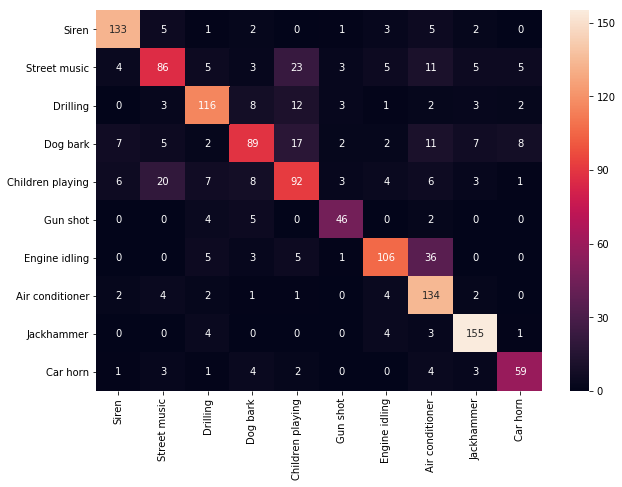

In [55]:
import seaborn as sn

df_cm = pd.DataFrame(returned, index = [i[1].replace('_', ' ').capitalize() for i in wavcatalog],
                  columns = [i[1].replace('_', ' ').capitalize() for i in wavcatalog])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')